In [4]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

In [15]:
def fit_subject(data, quantiles):
    subj_idx = data.iloc[0]['subj_idx']
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
#     m.map(runs=5)
    m.optimize('gsquare', quantiles=quantiles, n_runs=5)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def get_params(params, subj, condition=False):
    
    # Set parameters
    try:
        a = params.iloc[subj]['a({})'.format(condition)]
    except:
        a = params.iloc[subj]['a']
    try:
        v = params.iloc[subj]['v({})'.format(condition)]
    except:
        v = params.iloc[subj]['v']
    try:
        t = params.iloc[subj]['t({})'.format(condition)]
    except:
        t = params.iloc[subj]['t']
    try:
        z = params.iloc[subj]['z({})'.format(condition)]
    except:
        try:
            z = params.iloc[subj]['z']
        except:
            z = 0.5
    try:
        dc = params.iloc[subj]['dc({})'.format(condition)]
    except:
        try:
            dc = params.iloc[subj]['dc']
        except:
            dc = 0
    try:
        sv = params.iloc[subj]['sv']
    except: 
        sv = 0
    sz = 0
    st = 0
    
    return (z, a, v, dc, t, sv, sz, st)
    
def get_choice(row):

    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(z, a, v, dc, t, sv, sz, st, condition, nr_trials1, nr_trials2):
    
    parameters1 = {'v':v+dc, 'a':a, 't':t, 'sv':sv, 'z':z, 'sz': sz, 'st': st}
    parameters2 = {'v':v-dc, 'a':a, 't':t, 'sv':sv, 'z':1-z, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim
    
def model_fit(params, data, condition=False, quantiles=[.1, .3, .5, .7, .9], dt=0.01, stimulus_coding=True, nr_trials=10000):
    
    plot_nr = 1
    nogo = False
    
    nr_rows = int(np.ceil(params.shape[0] / 4.0)) + 1
    tmax = np.percentile(data.loc[~np.isnan(data.rt),'rt'], 97.5) + 0.1
    
    if np.all(~np.isnan(data['rt'])):
        fig = plt.figure(figsize=(6,nr_rows*1.5))
    else:
        fig = plt.figure(figsize=(8,nr_rows*1.5))
    
    for subj in np.unique(data['subj_idx']):
        
        # print:
        print("plot subj {}".format(subj))
        
        # empirical data:
        if condition == None:
            data_emp_subj = data.loc[(data['subj_idx']==subj)]
        else:
            data_emp_subj = data.loc[(data['subj_idx']==subj) & (data['condition']==condition)]
        
        # simulated data:
        z, a, v, dc, t, sv, sz, st = get_params(params=params, subj=subj, condition=condition)
        nr_trials1 = nr_trials
        scaling = nr_trials1 / data_emp_subj['stimulus'].sum()
        nr_trials2 = (data_emp_subj.shape[0] - data_emp_subj['stimulus'].sum()) * scaling
        data_sim_subj = simulate_data(z=z, a=a, v=v, dc=dc, t=t, sv=sv, sz=sz, st=st, condition=condition, nr_trials1=nr_trials1, nr_trials2=nr_trials2)
        
        # colors:
        colors = ['forestgreen', 'orange']
        
        # ax:
        ax = fig.add_subplot(nr_rows,4,plot_nr)
        for resp in [0,1]:
            
            data_emp = data_emp_subj.loc[data_emp_subj['response']==resp]
            data_sim = data_sim_subj.loc[data_sim_subj['response']==resp]
            
            if resp == 0:
                data_emp.loc[:,'rt'] = data_emp.loc[:,'rt'] * -1.0
                data_sim.loc[:,'rt'] = data_sim.loc[:,'rt'] * -1.0
            if (resp == 1) & nogo:
                ax=ax.twinx()
            
            if np.all(~np.isnan(data_emp['rt'])):
                break_points = np.percentile(data_emp.loc[:,'rt'], np.array(quantiles)*100)
                ax.hist(data_emp.loc[:,'rt'], bins=break_points, density=True, alpha=0.5, color=colors[resp])
                ax.hist(data_sim.loc[:,'rt'], bins=break_points, density=True, histtype='step', color='k')
                ax.set_xlim(-tmax,tmax)
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Trials (#)')
                # ax.set_title('S{}; stim={}'.format(subj, stim))
                ax.set_title('S{}'.format(subj))
            else:
                nogo = True
                empirical_no = data_emp.shape[0]
                predicted_no = data_sim.shape[0] / scaling
                ax.bar(x=0, height=empirical_no, width=0.3, alpha=0.5, color='forestgreen',)
                ax.hlines(y=predicted_no, xmin=-0.15, xmax=0.15, lw=0.5, colors='black', label='no')
                ax.vlines(x=-0.15, ymin=0, ymax=predicted_no, lw=0.5, colors='black', label='no')
                ax.vlines(x=0.15, ymin=0, ymax=predicted_no, lw=0.5, colors='black', label='no')
                
        plot_nr += 1
        
    plt.tight_layout()
    
    return fig

In [16]:
n_subjects = 4
trials_per_level = 1000
params0 = {'cond':0, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.7, 'dc':-0.2, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':0.7, 'a':2.0, 't':0.3, 'z':0.3, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}
quantiles = [.1, .3, .5, .7, .9]

In [22]:
# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], t=params0['t'], 
                                    sv=params0['sv'], st=params0['st'], sz=params0['sz'], condition=params0['cond'], 
                                    nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], t=params1['t'], 
                                    sv=params1['sv'], st=params1['st'], sz=params1['sz'], condition=params1['cond'], 
                                    nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)

df = pd.concat(dfs)    
df.loc[df["response"]==0, 'rt'] = np.NaN
df.to_csv('data.csv')

In [23]:
# fit:
params = Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles) for data in df.groupby('subj_idx'))
params = pd.concat(params, axis=0)

/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:662: RuntimeWarning: invalid value encountered in greater
  p_upper = float(np.mean(data>0))
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:663: RuntimeWarning: invalid value encountered in less
  q_lower = mquantiles(-data[data<0], quantiles)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:664: RuntimeWarning: invalid value encountered in greater
  q_upper = mquantiles(data[data>0], quantiles)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:662: RuntimeWarning: invalid value encountered in greater
  p_upper = float(np.mean(data>0))
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:663: RuntimeWarning: invalid value encountered in less
  q_lower = mquantiles(-data[data<0], quantiles)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/hddm/utils.py:664: RuntimeWarning: invalid val

Optimization terminated successfully.
         Current function value: 11526.098018
         Iterations: 5
         Function evaluations: 596
Optimization terminated successfully.
         Current function value: 11461.591151
Optimization terminated successfully.
         Current function value: 11370.810098
         Iterations: 7
         Function evaluations: 849
         Iterations: 7
         Function evaluations: 854
Optimization terminated successfully.
         Current function value: 11334.058830
         Iterations: 7
         Function evaluations: 861
Optimization terminated successfully.
         Current function value: 11519.278997
         Iterations: 7
         Function evaluations: 906
Optimization terminated successfully.
         Current function value: 11461.804013
         Iterations: 7
         Function evaluations: 853
Optimization terminated successfully.
         Current function value: 11371.718050
         Iterations: 7
         Function evaluations: 860
Optimi

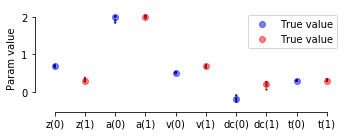

In [24]:
# parameter recovery plots:
params_recovered = params.loc[:, ['z(0)', 'z(1)', 'a(0)', 'a(1)', 'v(0)', 'v(1)', 'dc(0)', 'dc(1)', 't(0)', 't(1)']]
x = np.arange(5) * 2
y0 = np.array([params0['z'], params0['a'], params0['v'], params0['dc'], params0['t']])
y1 = np.array([params1['z'], params1['a'], params1['v'], params1['dc'], params1['t']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, color='blue', alpha=0.5, label='True value')
ax.scatter(x+1, y1, color='red', alpha=0.5, label='True value')
sns.stripplot(data=params_recovered, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['blue', 'red'], ax=ax)
sns.despine(offset=5, trim=True,)
plt.legend()
plt.ylabel('Param value')
plt.tight_layout()
fig.savefig(os.path.join('plots', 'model_recovery.png'))

plot subj 0
plot subj 1
plot subj 2
plot subj 3
plot subj 0
plot subj 1
plot subj 2
plot subj 3


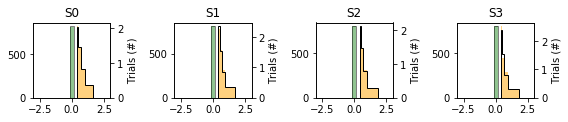

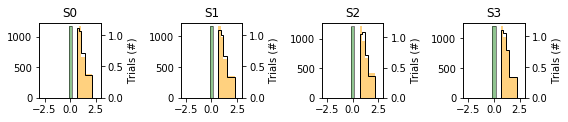

In [25]:
# model fits:
for condition in np.unique(df['condition']):
    fig = model_fit(params, df, condition=condition, quantiles=quantiles)
    fig.savefig(os.path.join('plots', 'model_fit_{}.png'.format(condition)))